In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

In [6]:
data = yf.download(["NVDA", "SPY"], start= datetime.today() - timedelta(days = 1825), end = datetime.today(), auto_adjust = True)["Close"]
NVDA = data["NVDA"]
SPY = data["SPY"]

[*********************100%***********************]  2 of 2 completed


# 2

## i

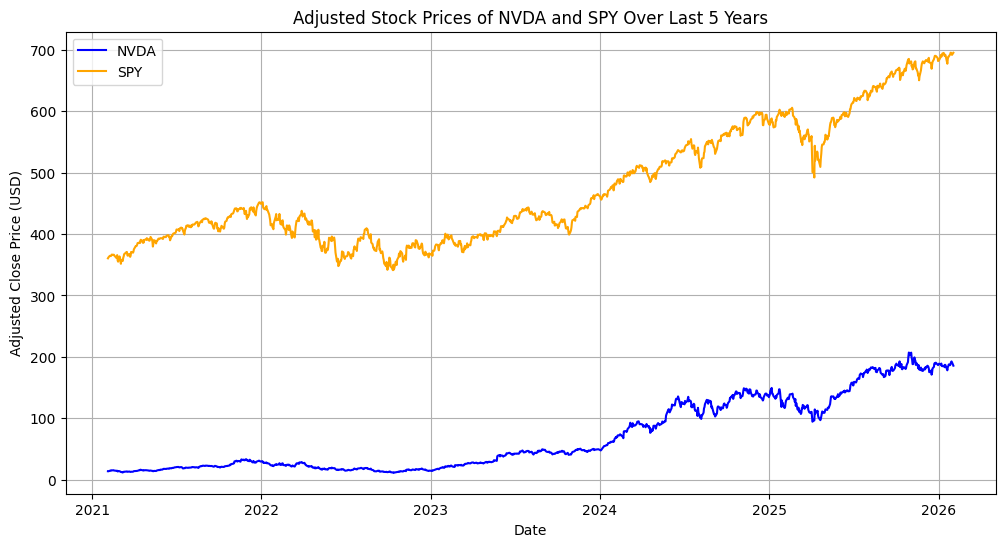

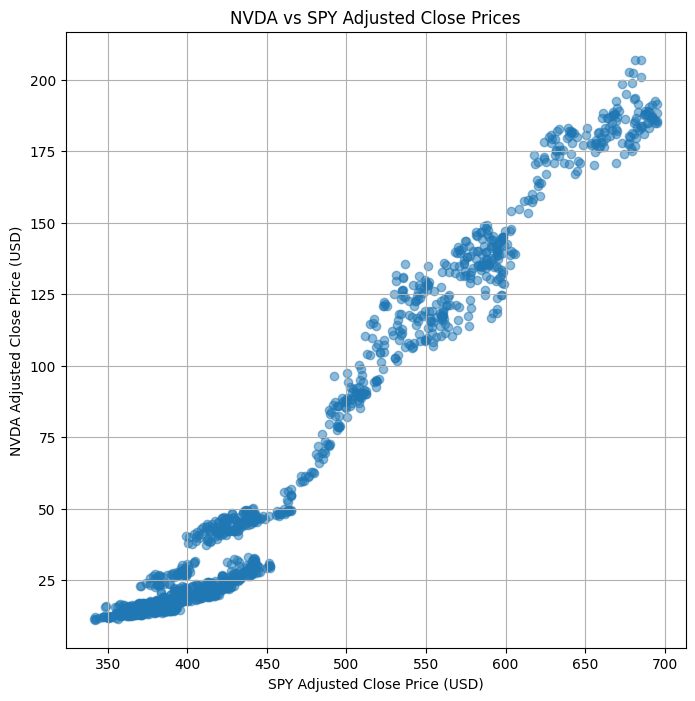

In [7]:
# plot adjusted stock prices as a function of time for both NVDA and SPY
plt.figure(figsize=(12, 6))
plt.plot(NVDA.index, NVDA.values, label='NVDA', color='blue')
plt.plot(SPY.index, SPY.values, label='SPY', color='orange')
plt.title('Adjusted Stock Prices of NVDA and SPY Over Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.grid()
plt.show()

# scatter plot of NVDA versus SPY on the same trading day
plt.figure(figsize=(8, 8))
plt.scatter(SPY.values, NVDA.values, alpha=0.5)
plt.title('NVDA vs SPY Adjusted Close Prices')
plt.xlabel('SPY Adjusted Close Price (USD)')
plt.ylabel('NVDA Adjusted Close Price (USD)')
plt.grid()
plt.show()

The two stock trends seem to be extremely similar, rising and dropping at
relatively the same times.

In [ ]:
from statsmodels.api import OLS, add_constant
X = add_constant(SPY.values)
model = OLS(NVDA.values, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 4.083e+04
Date:                Tue, 03 Feb 2026   Prob (F-statistic):               0.00
Time:                        14:25:41   Log-Likelihood:                -4689.0
No. Observations:                1254   AIC:                             9382.
Df Residuals:                    1252   BIC:                             9392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -211.8703      1.425   -148.689      0.0

**Intercept**: -211.8703, SE 1.425, p < 0.0001  
This is the predicted value of NVDA when SPY is valued at $0. This has no meaning 
in it of itself, however given its extremely low p-value, is obviously extremely 
relevant to the model as it anchors the regression line. The SE is also extremely
low, indicating a well estimated value.

**Coefficient**: 0.5929, SE 0.003, p < 0.0001  
For every $1 increase in SPY, NVDA is projected to increase by $0.5929. With 
an extremely low SE and p-value, this is a positive and highly significant correlation.

**R-Squared & Adjusted**: 0.970
This is extremely high, meaning that 97% of the variation in NVDA prices are
explained by SPY prices.

The very high R^2, t score, and confidence/p-value in the coefficients indicate
a strong linear correlation between NVDA and SPY price. However, the Durbin-Watson
score is 0.063. This is extremely low and a red flag in our model, as this indicates
extreme positive autocorrelation, violating the independent error assumption,
leading to an underestimation of the standard errors, which leads to inflated 
t-statistics and the false appearance of statistical significance. Thus,
while the conditional mean relationship is well approximated by a linear function, 
the error structure is misspecified.



## ii

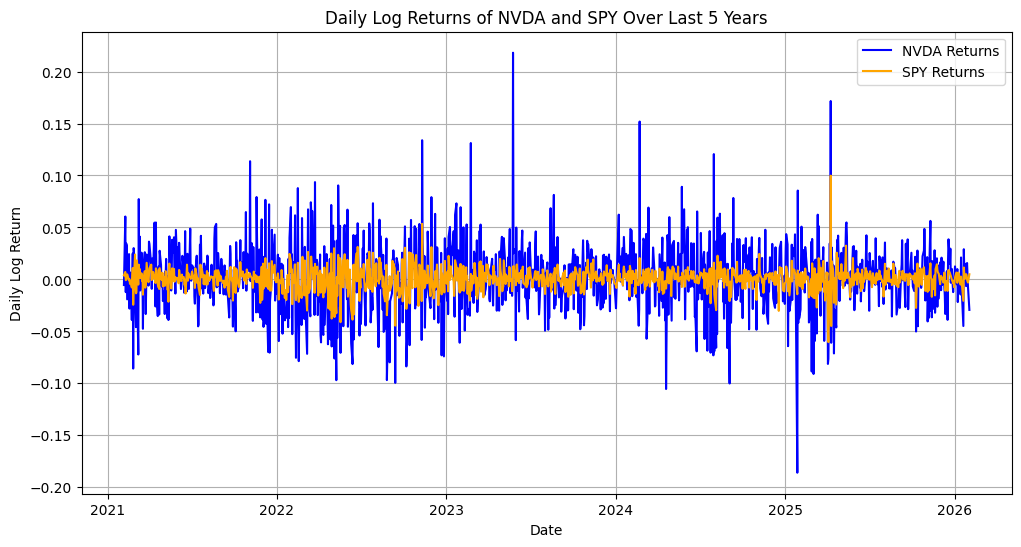

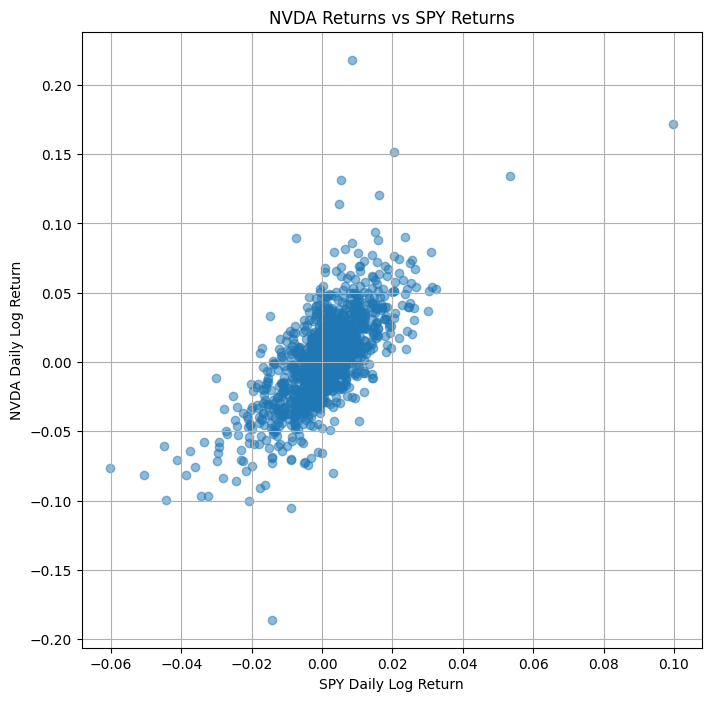

In [10]:
# daily log returns of NVDA and SPY
NVDA_returns = np.log(NVDA / NVDA.shift(1))
SPY_returns = np.log(SPY / SPY.shift(1))

# plot daily log returns for both NVDA and SPY
plt.figure(figsize=(12, 6))
plt.plot(NVDA_returns.index, NVDA_returns.values, label='NVDA Returns', color='blue')
plt.plot(SPY_returns.index, SPY_returns.values, label='SPY Returns', color='orange')
plt.title('Daily Log Returns of NVDA and SPY Over Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Daily Log Return')
plt.legend()
plt.grid()
plt.show()

# scatter plot of NVDA returns versus SPY returns on the same trading day
plt.figure(figsize=(8, 8))
plt.scatter(SPY_returns.values, NVDA_returns.values, alpha=0.5)
plt.title('NVDA Returns vs SPY Returns')
plt.xlabel('SPY Daily Log Return')
plt.ylabel('NVDA Daily Log Return')
plt.grid()
plt.show()

In [11]:
# fit CAPM regression r_theta_NVDA = alpha + beta * r_theta_SPY + epsilon_t
X_returns = add_constant(SPY_returns.values[1:])  # exclude NaN from shift
model_returns = OLS(NVDA_returns.values[1:], X_returns).fit()
print(model_returns.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     1226.
Date:                Tue, 03 Feb 2026   Prob (F-statistic):          9.73e-188
Time:                        15:24:18   Log-Likelihood:                 2941.8
No. Observations:                1253   AIC:                            -5880.
Df Residuals:                    1251   BIC:                            -5869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.471      0.1